# Bootstrapping: Emittance uncertainty calculation

In [1]:
import statistics
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from random import seed

#### First, reading the raw data and displaying them in a dataframe.

In [2]:
I_meas, sigm = np.loadtxt('1_medida_emittance_planeX_E_147.8_MULTIBUNCH2.txt', skiprows=2, unpack=True)
current, err_current, sigma,err_sigma  = [],[],[],[]
for i in range(0, len(I_meas), 4):
    current.append(np.mean(I_meas[i:i+4]))
    err_current.append(np.std(I_meas[i:i+4]))
    sigma.append(np.mean(sigm[i:i+4]))
    err_sigma.append(np.std(sigm[i:i+4]))
Data = pd.DataFrame({' Current [A]':current,
                     '$\pm$ uncert. [A]': err_current,
                     'Beam size [mm]':np.array(sigma)*1000,
                     '$\pm$ uncert. [mm]': np.array(err_sigma)*1000})
Data

,Current [A],$\pm$ uncert. [A],Beam size [mm],$\pm$ uncert. [mm]
0,0.500139,0.000666,0.923498,0.008285
1,0.619840,0.000896,0.861830,0.007841
2,0.740328,0.000227,0.792794,0.007036
3,0.859553,0.000770,0.760187,0.008366
4,0.980407,0.000316,0.746459,0.000241
5,1.100016,0.000787,0.745868,0.000243
6,1.220637,0.000633,0.781876,0.004196
7,1.340480,0.000545,0.834189,0.008481
8,1.459988,0.000628,0.888755,0.007457
9,1.579458,0.000495,0.959203,0.001335


#### Setting the experimental set-up data

In [3]:
I2K1 = [-0.0089, 2.1891, 0.0493] # Fitting values to transform from current to quadrupole strength
DIST = 2.8775                    # Space (drift) between the quadrupole and the camera
QUAD_L = 0.112                   # Quadrupole length
light_speed = 299792458          # in m/s
electron_rest_en = 0.5109989461  # in MeV
energy = 147.8                   # beam energy in MeV

In [4]:
def _get_K1_from_I(energy, I_meas):
    '''Function to calculate the quadrupole strength using the quadrupole current'''
    kin_en = np.sqrt(energy*energy - electron_rest_en*electron_rest_en)
    return np.polyval(I2K1, I_meas)*light_speed/kin_en/1e6

In [5]:
def _twiss(s_11 , s_12, s_22, energy):
    '''Funtion to calculate the normalize emittance and the 
       twiss parameters using the components of the emittance matrix'''
    emit = np.sqrt(abs(s_11 * s_22 - s_12 * s_12))
    beta = s_11 / emit
    alpha = -s_12 / emit
    gamma = s_22 / emit
    nemit = emit * energy / electron_rest_en * 1e6  # in mm.mrad
    return nemit, beta, alpha, gamma

In [6]:
def _trans_matrix_method(energy, I_meas, sigma, pl='x'):
    '''Function to calculate the beam emittance using transfer matrices'''
    K1 = _get_K1_from_I(energy,I_meas)
    Rx, Ry = _get_resp_mat(K1, energy)
    R = Rx if pl == 'x' else Ry
    pseudo_inv = np.dot(np.linalg.inv(np.dot(np.transpose(R) , R)) , np.transpose(R))
    [s_11, s_12, s_22] = pseudo_inv @ (sigma*sigma)
    #s_11, s_12, s_22 = np.linalg.lstsq(R, sigma * sigma, rcond=None)[0]
    nemit, beta, alpha, gamma = _twiss(s_11, s_12, s_22, energy)
    return nemit, beta, alpha, gamma

In [7]:
def _thin_lens_method(energy, I_meas, sigma, pl='x'):
    '''Function to calculate the beam emittance using the thin lens approximation 
      method with quadratic fitting parameters'''
    I_meas2 = I_meas if pl == 'x' else -I_meas
    K1 = _get_K1_from_I(energy,I_meas2)
    
    a, b, c = np.polyfit(K1, sigma*sigma, 2)
    yd = np.sqrt(np.polyval([a, b, c], K1))

    d = DIST + QUAD_L/2
    l = QUAD_L
    s_11 = a/(d*l)**2
    s_12 = (-b-2*d*l*s_11)/(2*l*d*d)
    s_22 = (c-s_11-2*d*s_12)/d**2
    nemit, beta, alpha, gamma = _twiss(s_11, s_12, s_22, energy)
    return nemit, beta, alpha, gamma

In [8]:
def gettransmat(type, L, gamma, K1=None, B=None):
    '''Function to calculate a transfer matrix'''
    R = np.eye(6)

    if type.lower().startswith('qu') and K1 is not None and K1 == 0:
        type = 'drift'
    if type.lower().startswith('dr'):
        R = np.array([
            [1, L, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, L, 0, 0],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, L/gamma**2],
            [0, 0, 0, 0, 0, 1],
            ])
    elif type.lower().startswith('qu') and K1 is not None:
        kq = np.sqrt(abs(K1))
        c = np.cos(kq*L)
        s = np.sin(kq*L)
        ch = np.cosh(kq*L)
        sh = np.sinh(kq*L)
        if K1 > 0:
            x11, x12, x21 = c,  1/kq*s, -kq*s
            y11, y12, y21 = ch, 1/kq*sh, kq*sh
        else:
            x11, x12, x21 = ch, 1/kq*sh, kq*sh
            y11, y12, y21 = c,  1/kq*s, -kq*s
        R = np.array([
            [x11, x12, 0,   0,   0, 0],
            [x21, x11, 0,   0,   0, 0],
            [0,   0,   y11, y12, 0, 0],
            [0,   0,   y21, y11, 0, 0],
            [0,   0,   0,   0,   1, L/gamma**2],
            [0,   0,   0,   0,   0, 1],
            ])
    elif type.lower().startswith('sol') and B is not None:
        K = -light_speed*B/2.0/electron_rest_en/gamma/1e6
        C = np.cos(K*L)
        S = np.sin(K*L)
        SC = C*S
        C2 = C**2
        S2 = S**2
        R = np.array([
            [C2,    SC/K,  SC,    S2/K, 0., 0.],
            [-K*SC, C2,    -K*S2, SC,   0., 0.],
            [-SC,   -S2/K, C2,    SC/K, 0., 0.],
            [K*S2,  -SC,   -K*SC, C2,   0., 0.],
            [0.,    0.,    0.,    0.,   1., L/(gamma**2)],
            [0.,    0.,    0.,    0.,   0., 1.]
            ])
    return R

In [9]:
def _get_resp_mat(K1, energy):
    '''Function to calculate the total transfer matrix of the experiment'''
    gamma = energy/electron_rest_en
    R = np.zeros((len(K1), 6, 6))
    Rd = gettransmat('drift', L=DIST, gamma=gamma)
    for i, k1 in enumerate(K1):
        Rq = gettransmat('quad', L = QUAD_L, gamma=gamma, K1=k1)
        R[i] = np.dot(Rd, Rq)
    R11 = R[:, 0, 0].reshape(-1, 1)
    R12 = R[:, 0, 1].reshape(-1, 1)
    R33 = R[:, 2, 2].reshape(-1, 1)
    R34 = R[:, 2, 3].reshape(-1, 1)
    Rx = np.column_stack((R11*R11, 2*R11*R12, R12*R12))
    Ry = np.column_stack((R33*R33, 2*R33*R34, R34*R34))
    return Rx, Ry

In [14]:
def t_test(data1, data2):
    '''Function to calculate the t-student test given two arrays'''
    f=(data1.std()**2/data2.std()**2)
    if f>0.5 and f<2:
        t, p = stats.ttest_ind(data1,data2, equal_var=True)
    else:
        t, p = stats.ttest_ind(data1,data2, equal_var=False)
    return t, p, f

In [15]:
def plot_histo(data_tm, data_tl, xaxis= r'$\epsilon$ [mmm.rad]'):
    '''Function to plot two histograms with  their main properties'''
    te, pe, fe = t_test(data_tm, data_tl)
    qx, by, n = plt.hist(data_tm, bins=50, range=[min(data_tm), max(data_tm)], fc='none',
                         histtype='step', color='black', label='TM', linewidth=.8)
    plt.text(max(by) , max(qx),'$\mu$: '+str(round(data_tm.mean(),4))+'\n $\sigma$: '+
             str(round(stats.sem(data_tm),4)), va="top", ha="right", bbox={'facecolor':
            'white', 'alpha': 0.5, 'pad': 10},color='black', fontdict={'weight' : 'bold', 'fontsize': 10})
    qx1, by1, n1 = plt.hist(data_tl, bins=50, range=[min(data_tl), max(data_tl)],  fc='none',
                            histtype='step', color = 'maroon', label='TL', linewidth=.8)
    plt.text(min(by1) , max(qx),'$\mu$: '+str(round(data_tl.mean(),4))+'\n $\sigma$: '+
             str(round(stats.sem(data_tl),4))+'\n f: '+str(round(fe,4))+'\n t: '+
             str(round(te,4)) +'\n p: '+str(round(pe,4)), va="top", ha="left", 
             bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10}, color='maroon', 
             fontdict={'fontsize': 10,'weight' : 'bold'})
    plt.legend(loc='lower right')
    plt.xlabel(xaxis, x=1, ha='right',size= 10 )
    plt.ylabel('amplitude', y=1, ha='right',size= 10)
    plt.show()

In [12]:
def emit_montec(energy, sigma, error, I_meas, plane):
    '''Function to resample the raw data and calculate the beam emittance uncertainty'''
    a1, b1, c1 = np.polyfit(I_meas, np.array(sigma)*1000, 2)
    a2, b2, c2 = np.polyfit(I_meas, np.array(sigma)*1000, 2, w=1/np.array(error)**2)
    I = np.linspace(min(I_meas), max(I_meas), 100)
    plt.plot(I , c1+b1*I+a1*I**2, '--', label = 'Unweigted fitting')
    plt.plot(I , c2+b2*I+a2*I**2, '--', label = 'Weigted fitting')
    plt.errorbar( I_meas,np.array(sigma)*1000, yerr= np.array(error)*1000, fmt = 'ro', markersize = 3, 
             ecolor = 'red', capsize = 3,  linewidth = 0.5, 
             color = 'darkblue', label = "Experimental Data")
    plt.xlabel('Current [A]')
    plt.ylabel('Beam size [mm]')
    plt.legend()
    plt.show()
    sigma_montecarlo = []
    M = 10000
    #seed(30)
    nemit_t,beta_t, alpha_t,gamma_t =np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M)
    nemit_tl, beta_tl, alpha_tl, gamma_tl = np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M)
    for m in range(M):
        sigma_mont_s = []
        for i in range(len(sigma)):
            sigma_mont_s.append(sigma[i] + error[i]*np.random.randn())
        sigma_mont_s = np.array(sigma_mont_s)
        nemit_t[m], beta_t[m],alpha_t[m],gamma_t[m] =  _trans_matrix_method(energy, I_meas, sigma_mont_s, pl=plane)
        nemit_tl[m], beta_tl[m], alpha_tl[m], gamma_tl[m] =_thin_lens_method(energy, I_meas, sigma_mont_s, pl=plane)
        nemit_tl[m], beta_tl[m], alpha_tl[m], gamma_tl[m] =_thin_lens_method(energy, I_meas, sigma_mont_s, pl=plane)

    plot_histo(nemit_t, nemit_tl, xaxis= r'$\epsilon$ [mm.mrad]')
    plot_histo(beta_t, beta_tl, xaxis= r'$\beta$ [m]')
    plot_histo(alpha_t, alpha_tl, xaxis= r'$\alpha$')
    plot_histo(gamma_t, gamma_tl, xaxis= r'$\gamma$ [1/m]')

#### Test of the Bootstrap method to calculate the emittance uncertainty

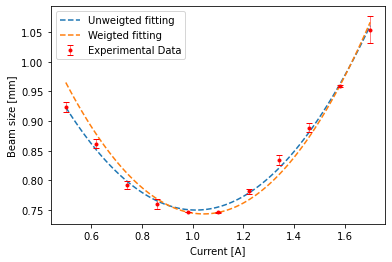

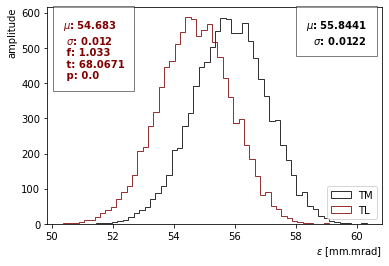

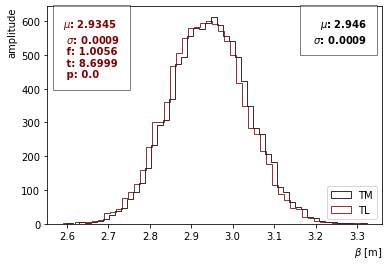

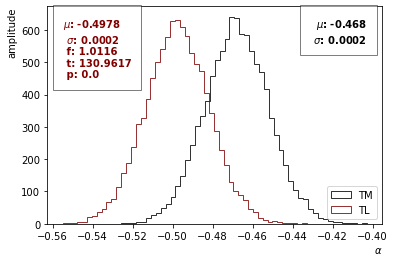

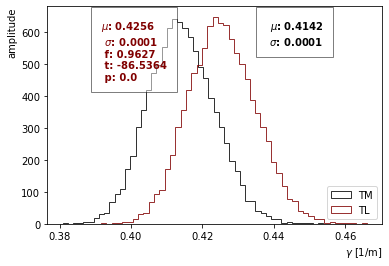

In [16]:
emit_montec(147.8, sigma,err_sigma, current, 'x')